Imports used are added in here.

In [447]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from PIL import ImageDraw
from scipy.optimize import bisect
import os


Functions used will be added in here.

Testing the Image quality

In [448]:
def compute_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    psnr = 10 * np.log10(255**2 / mse)
    return mse, psnr

Week 1


In [449]:
# --------------------------
# Week 1: Image Generation
# --------------------------

def create_striped_image(width, height, spacing, thickness=1, orientation='vertical'):
    img = Image.new("RGB", (width, height), "black")
    draw = ImageDraw.Draw(img)
    
    if orientation == 'vertical':
        for x in range(0, width, spacing):
            draw.line([(x, 0), (x, height)], fill="white", width=thickness)
    elif orientation == 'horizontal':
        for y in range(0, height, spacing):
            draw.line([(0, y), (width, y)], fill="white", width=thickness)
    img_path = f"{orientation}_stripes_{width}_{height}_{spacing}_{thickness}.png"
    img.save(img_path)
    return img_path

def create_dotted_image(width, height, spacing, dot_size):
    img = Image.new("RGB", (width, height), "black")
    draw = ImageDraw.Draw(img)
    for x in range(0, width, spacing):
        for y in range(0, height, spacing):
            draw.rectangle([x, y, x+dot_size-1, y+dot_size-1], fill="white")
    img_path = f"dots_{width}_{height}_{spacing}_{dot_size}.png"
    img.save(img_path)
    return img_path

# Display the images from files
def show_image(image_file, title='', cmap='gray'):
    image = Image.open(image_file)
    image_array = np.array(image)
    plt.imshow(image_array, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def show_image_array(image_array, title='', cmap='gray'):
    plt.imshow(image_array, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

Week 2 

In [450]:
# --------------------------
# Week 2: FFT Analysis
# --------------------------

def compute_fft(image_path):
    # Load the image in grayscale
    img = Image.open(image_path).convert("L")
    img_array = np.array(img)
    fft_result = np.fft.fft2(img_array)
    power_spectrum = np.abs(fft_result) ** 2
    log_power_spectrum = np.log(1.0 + power_spectrum)
    return fft_result, power_spectrum, log_power_spectrum, img_array

def plot_fft_results(image_path):
    fft_result, power, log_power, img_array = compute_fft(image_path)
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    axs = axs.flatten()
    axs[0].imshow(img_array, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')


    axs[1].imshow(np.fft.fftshift(power), cmap='gray')
    axs[1].set_title("Power Spectrum")
    axs[1].axis('off')


    axs[2].imshow(np.fft.fftshift(log_power), cmap='gray')
    axs[2].set_title("Log Power Spectrum")
    axs[2].axis('off')

    plt.tight_layout()

# --------------------------
# Inverse FFT
# --------------------------

def compute_ifft(fft_data):
    # Compute inverse 2D FFT, appropriately normalised
    M, N = fft_data.shape
    ifft_result = np.fft.ifft2(fft_data)
    return np.abs(ifft_result) / (M * N)

# --------------------------
# Slashed Image Generation
# --------------------------
def create_slashed_image(width,height,spacing):
    # Create a black background image
    img = Image.new("RGB", (width, height), "black")
    draw = ImageDraw.Draw(img)

    # Draw vertical white lines
    for x in range(0, width, spacing):
        for y in range(0, height, spacing):
            draw.line([(x, y), (x-2, y+2)], fill="white", width=1)
        

    # Save the image
    img.save("slashed_image_%d_%d_%d.png" % (width,height,spacing))

Week 3

In [451]:
# --------------------------
# Week 3: Filtering
# --------------------------

def threshold_fft(fft_data, T):
    mask = np.abs(fft_data) >= T
    filtered_fft = fft_data * mask
    g_T = np.count_nonzero(mask)
    return filtered_fft, g_T

def calc_g(fft_result, T_start, T_end, interval=1):
    g_T = np.zeros(int((T_end-T_start)/(10**interval)))
    for i, T in list(enumerate(range(T_start, T_end, 10**interval ))):
        A = threshold_fft(fft_result,T)
        g_T[i] = A[1]
    return g_T

Week 4

In [452]:
# --------------------------
# Week 4: Compression
# --------------------------

def h_function(T, fft_array, r, M, N):
    _, g_T = threshold_fft(fft_array, T)
    return g_T - r * M * N

def compress_image(filename, r_values):
    # Load and transform
    img = Image.open(filename).convert("L")
    img_array = np.array(img)
    fft_array, power_spectrum, log_power_spectrum, img_array1 = compute_fft(filename)
    M, N = img_array.shape
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    axs[0].imshow(img_array, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    for i in range(len(r_values)):
        r= r_values[i]
        print(f" Compression ratio r = {r} ---")

        # Root finding to solve h(T) = 0
        h = lambda T: h_function(T, fft_array, r, M, N)
        
        # Estimate sensible T bounds
        mag = np.abs(fft_array)
        T_min, T_max = np.min(mag), np.max(mag)

        # Solve for T using bisection method
        T_opt = bisect(h, T_min, T_max, xtol=1e-3)
        print(f"Optimal threshold T = {T_opt:.3f}")

        # Apply threshold
        fft_thresh, g_T = threshold_fft(fft_array, T_opt)
        compression_ratio = g_T / (M * N)
        print(f"Verified compression ratio = {compression_ratio:.5f}")

        # Inverse transform
        compressed_image = compute_ifft(fft_thresh)

        mse, psnr = compute_psnr(img_array, compressed_image)
        print(f"MSE: {mse:.2f}, PSNR: {psnr:.4f} dB")

        #plot results
        axs[i+1].imshow(compressed_image, cmap='gray')
        axs[i+1].set_title(f"Compressed Image (r = {r})")
        axs[i+1].axis('off')
        
    plt.tight_layout()
    plt.show()

Tasks of Each Week

Week 1
 1) Modify your code so that you can vary also the line thickness.
 2) Add functionality to your code to create horizontal instead of vertical lines.
 3) Add functionality to your code to generate regularly spaced square dots of a chosen size

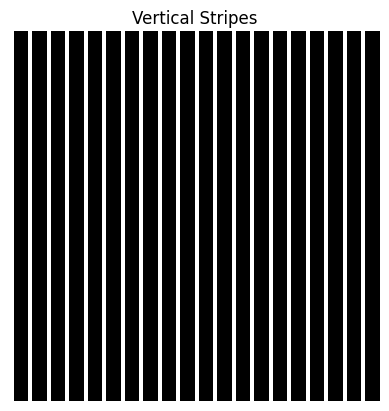

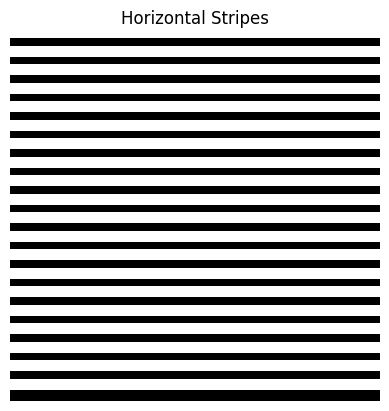

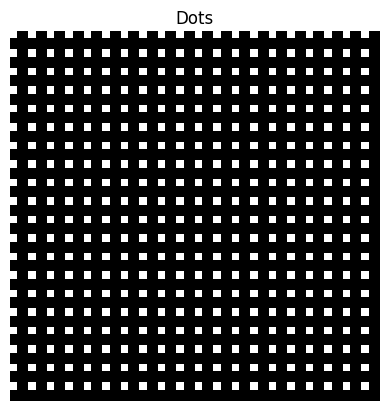

In [453]:
#First let’s create an image file with some vertical
#white lines on a black background
width, height = 100, 100 # Image dimensions
spacing = 5 # Spacing between lines
thickness = 2 # Thickness of lines
orientation = 'vertical' # Orientation of stripes
#Create the striped image
image_file1 = create_striped_image(width, height, spacing)

#Now, load in the image data:

show_image(image_file1, "Vertical Stripes", cmap='gray')


thickness = 3
spacing = 5
orientation = 'horizontal'
#Create the striped image
image_file2 = create_striped_image(width, height, spacing, thickness, orientation)
#Open the image file using PIL
show_image(image_file2, "Horizontal Stripes", cmap='gray')


image_file3 = create_dotted_image(width, height, spacing, dot_size=2)
#Open the image file using PIL
show_image(image_file3, "Dots", cmap='gray')


Week 2
1) Write code to plot the power spectrum and the log of the power spectrum of the images you generated
 last week.

Power Spectrum and log spectrum of Vertical Stripes


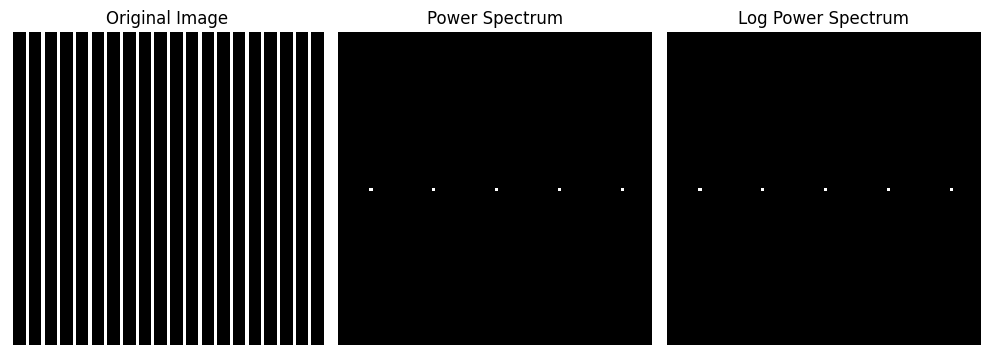

Power Spectrum and log spectrum of Horizontal Stripes


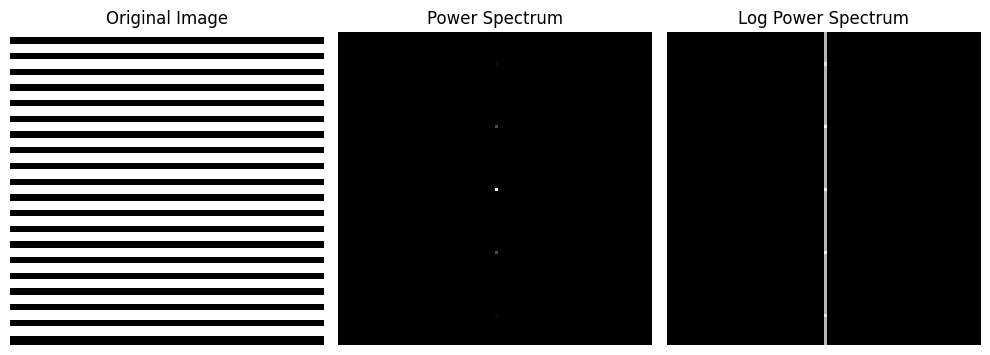

Power Spectrum and log spectrum of Dots


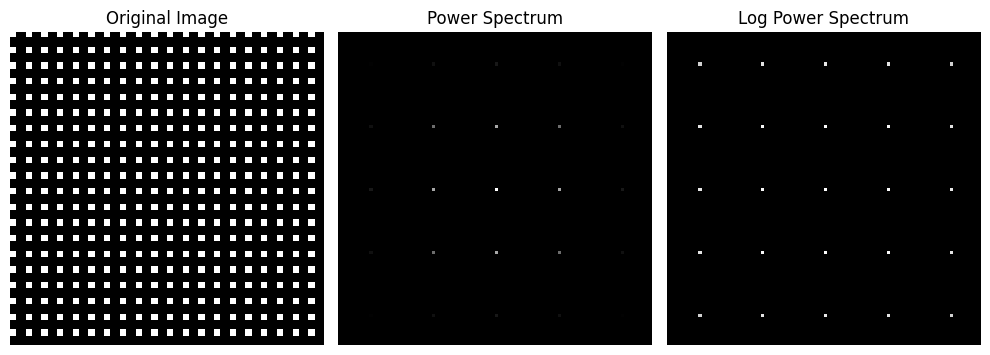

In [454]:
# Compute the FFFT of the image of the vertical stripes
# Power Spectrum and log spectrum of Vertical Stripes
print("Power Spectrum and log spectrum of Vertical Stripes")
plot_fft_results(image_file1)
plt.show()


# Power Spectrum and log spectrum of of the horizontal stripes
print("Power Spectrum and log spectrum of Horizontal Stripes")
plot_fft_results(image_file2)
plt.show()


# Power Spectrum and log spectrum of of the dots
print("Power Spectrum and log spectrum of Dots")
plot_fft_results(image_file3)
plt.show()




2)  For vertical lines with a spacing of 5 and a width of 1, what power spectrum do you get?

Power Spectrum and log spectrum of Vertical Stripes


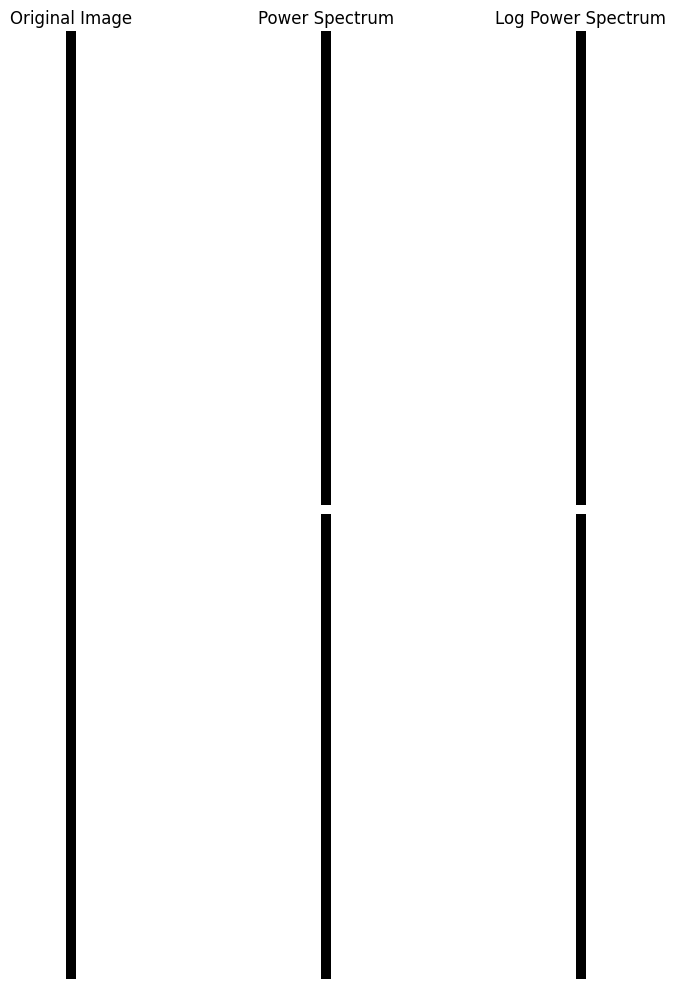

In [455]:
width = 1
spacing = 5
thickness = 2
height = 100
orientation = 'vertical'

#Create the striped image
image_file4 = create_striped_image(width, height, spacing, thickness, orientation)
# Compute the FFT of the image of the vertical stripes
# Power Spectrum and log spectrum of Vertical Stripes
print("Power Spectrum and log spectrum of Vertical Stripes")
plot_fft_results(image_file4)
plt.show()



3) How does the power spectrum change for horizontal lines with a spacing of 5 and a width of 1

Power Spectrum and log spectrum of Horizontal Stripes


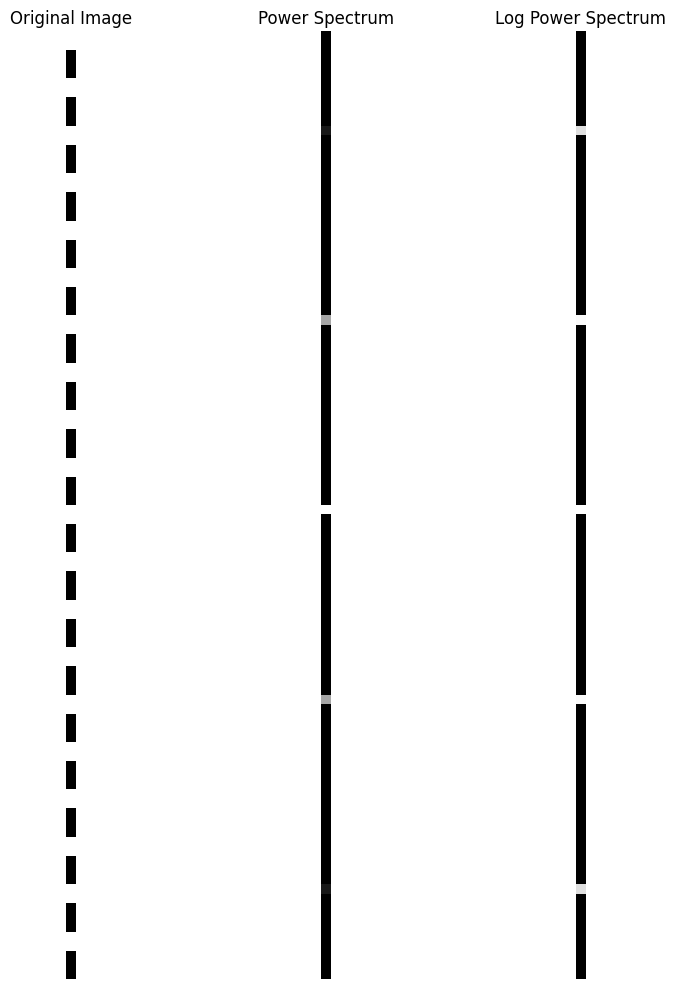

In [456]:
width = 1
spacing = 5
thickness = 2
height = 100
orientation = 'horizontal'

#Create the striped image
image_file5 = create_striped_image(width, height, spacing, thickness, orientation)
# Compute the FFT of the image of the horizontal stripes
# Power Spectrum and log spectrum of horizontal Stripes
print("Power Spectrum and log spectrum of Horizontal Stripes")
plot_fft_results(image_file5)
plt.show()



4) Adapt your code to plot the power spectrum for an image of regularly spaced ‘slash’ symbols. Is the power
 spectrum as you expected?

Image array shape: (100, 100, 3)


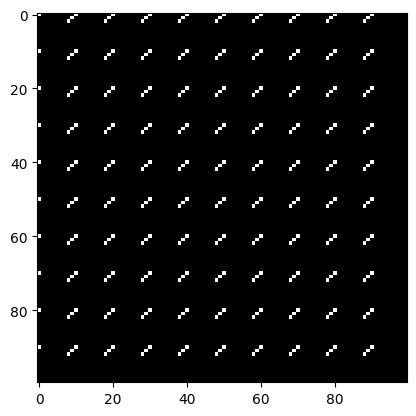

Power Spectrum and log spectrum of slashed image


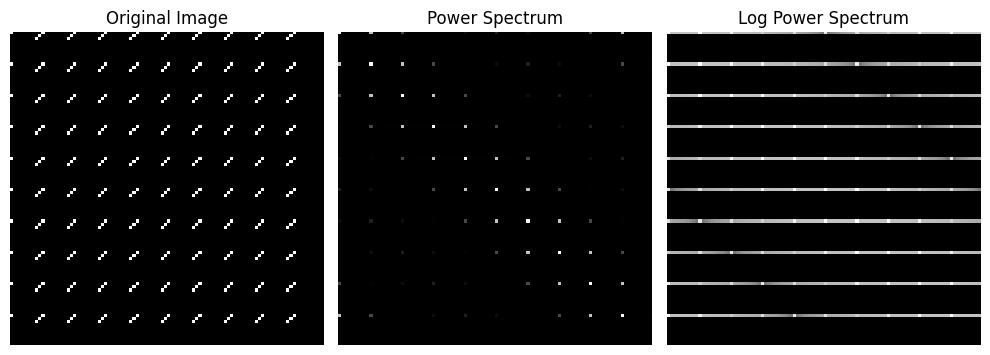

In [462]:
width, height = 100, 100 # Image dimensions
spacing = 10 # Spacing between lines
create_slashed_image(width, height, spacing)

#Now, load in the image data:
image_file = 'slashed_image_%d_%d_%d.png' % (width,height,spacing)

#Open the image file using PIL
image = Image.open(image_file)

#Convert the image to a NumPy array
image_array = np.array(image)

#Print the shape of the image array to verify
print('Image array shape:', image_array.shape)
#Display the image array:
plt.imshow(image_array)
plt.show()

# Compute the FFT of the image of the slashed image
# Power Spectrum and log spectrum of slashed image
print("Power Spectrum and log spectrum of slashed image")
plot_fft_results(image_file)
plt.show()

5) Calculate the power spectrum of each image ('funky.png' and 'owl.png')
6) Perform an inverse Fourier transform and verify that we can get back the image we started with.


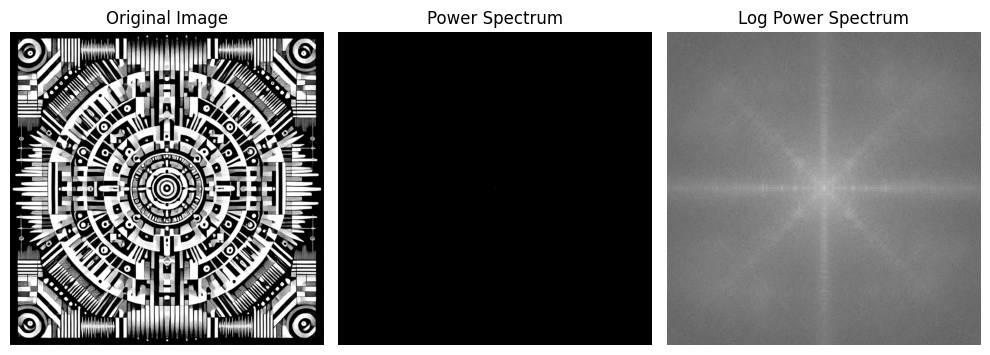

Max error: 254.99975681304932


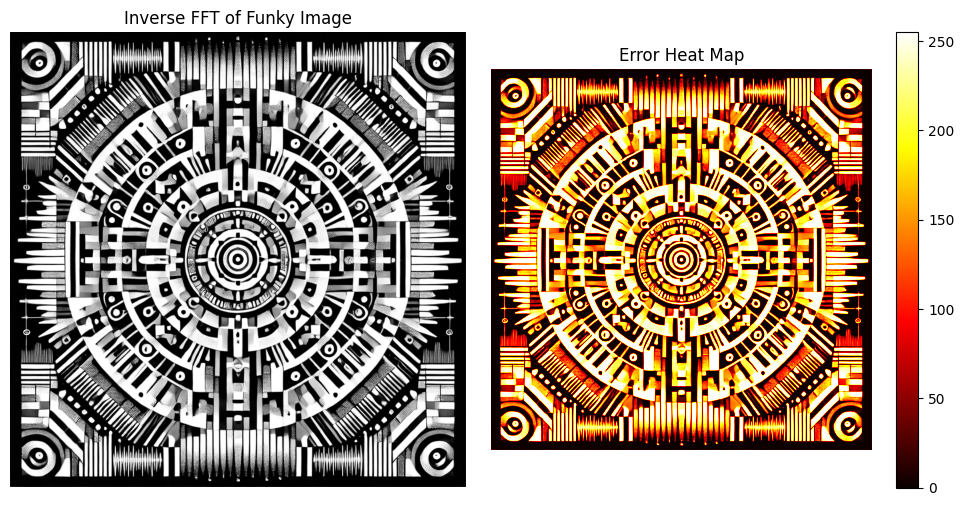

MSE: 24704.88, PSNR: 4.20 dB


In [458]:
# Compute the FFT of the image
image_file = 'funky.png'
# Power Spectrum and log spectrum of Funky Image
plot_fft_results(image_file)
plt.show()

#Compute the FFT
fft_result_funky, _, _, img_array_funky = compute_fft(image_file)
# Compute the inverse FFT
ifft_result_funky = compute_ifft(fft_result_funky)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(ifft_result_funky, cmap='gray')
axs[0].set_title('Inverse FFT of Funky Image')
axs[0].axis('off')


error = np.abs(img_array_funky - ifft_result_funky)
print("Max error:", np.max(error))

cax = axs[1].imshow(error, cmap='hot')
axs[1].set_title('Error Heat Map')
axs[1].axis('off')
fig.colorbar(cax, ax=axs[1], orientation='vertical')
plt.tight_layout()
plt.show()

mse, psnr = compute_psnr(img_array_funky, ifft_result_funky)
print(f"MSE: {mse:.2f}, PSNR: {psnr:.2f} dB")


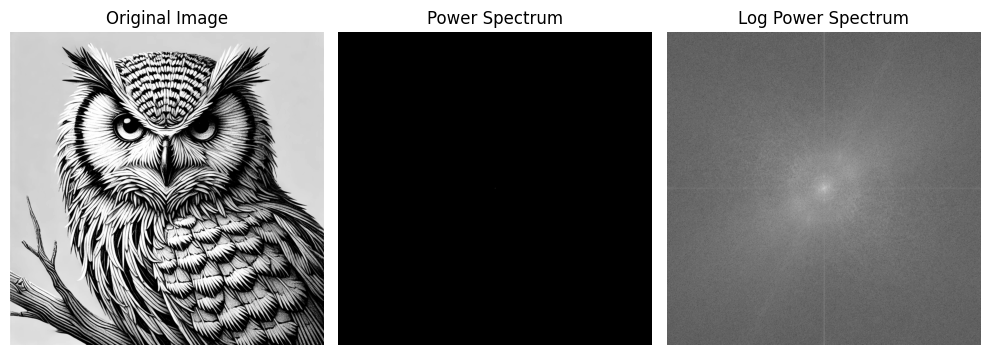

Max error: 255.0


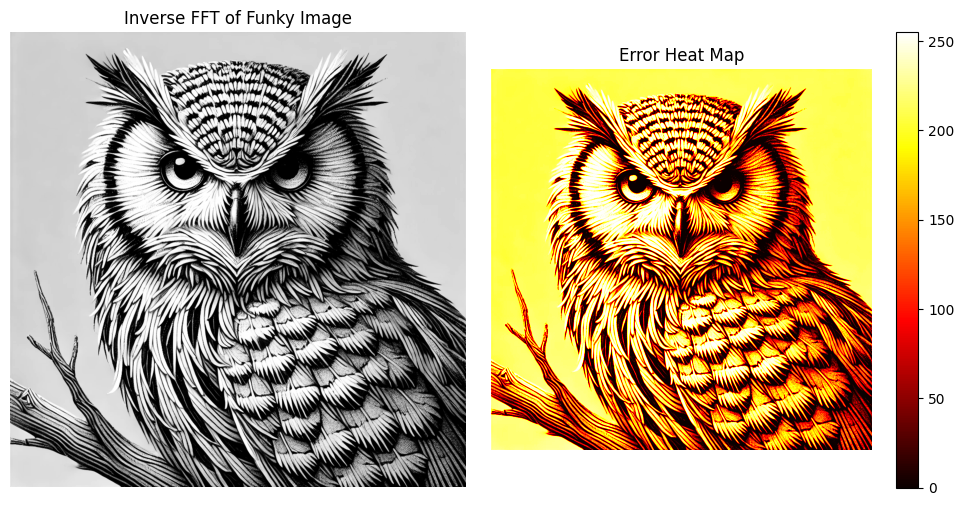

MSE: 29680.64, PSNR: 3.41 dB


In [459]:
# Compute the FFT of the image
image_file = 'owl.png'
# Power Spectrum and log spectrum of Owl Image
plot_fft_results(image_file)
plt.show()

# Compute the FFT
fft_result_owl, _, _, image_array_owl= compute_fft(image_file)
# Compute the inverse FFT
ifft_result_owl = compute_ifft(fft_result_owl)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ifft_result_owl, cmap='gray')
ax[0].set_title('Inverse FFT of Funky Image')
ax[0].axis('off')

error = np.abs(image_array_owl - ifft_result_funky)
print("Max error:", np.max(error))

cax = ax[1].imshow(error, cmap='hot')
ax[1].set_title('Error Heat Map')
ax[1].axis('off')
fig.colorbar(cax, ax=ax[1], orientation='vertical')
plt.tight_layout()
plt.show()

mse, psnr = compute_psnr(image_array_owl, ifft_result_owl)
print(f"MSE: {mse:.2f}, PSNR: {psnr:.2f} dB")


Week 3

100


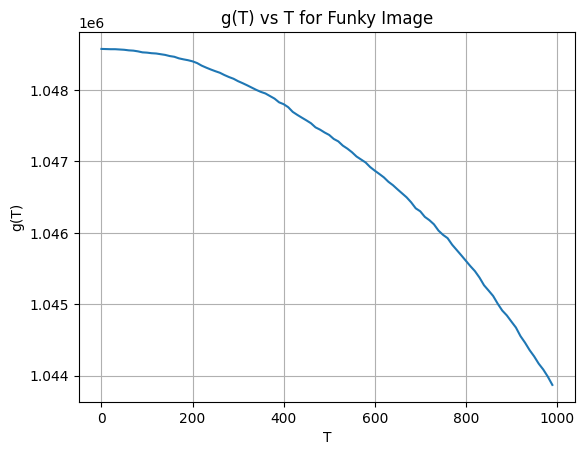

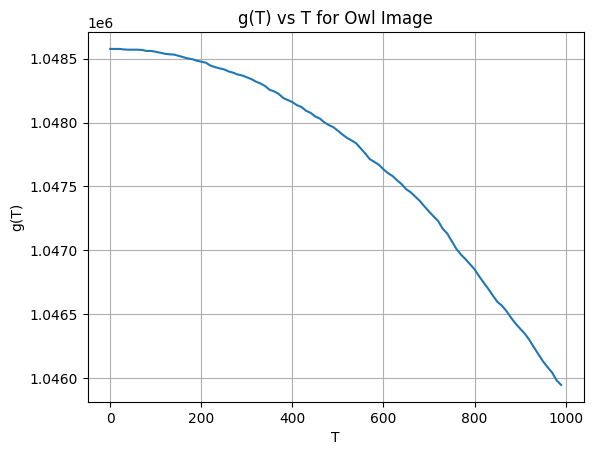

Compression Ratio for funky: 0.0020723342895507812


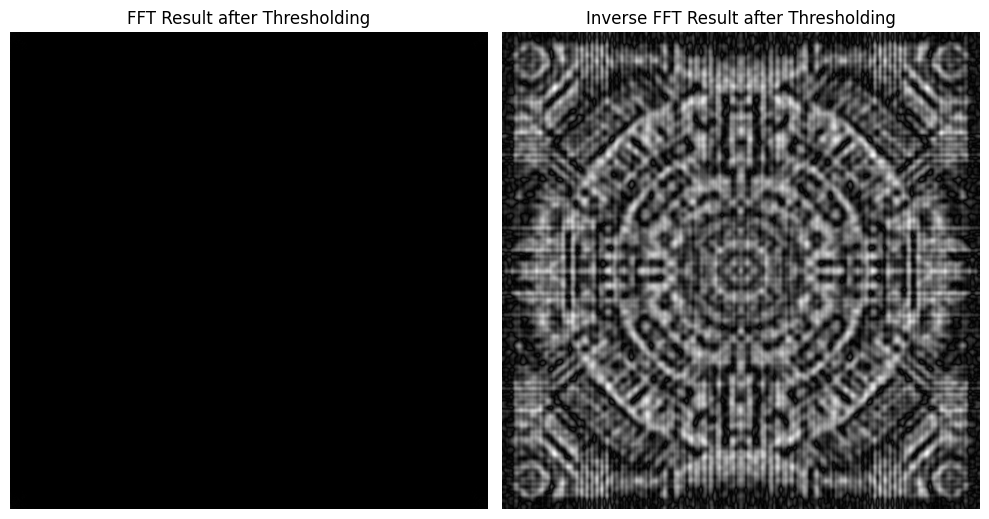

Max error of funky image after thresholding: 254.99999936893622


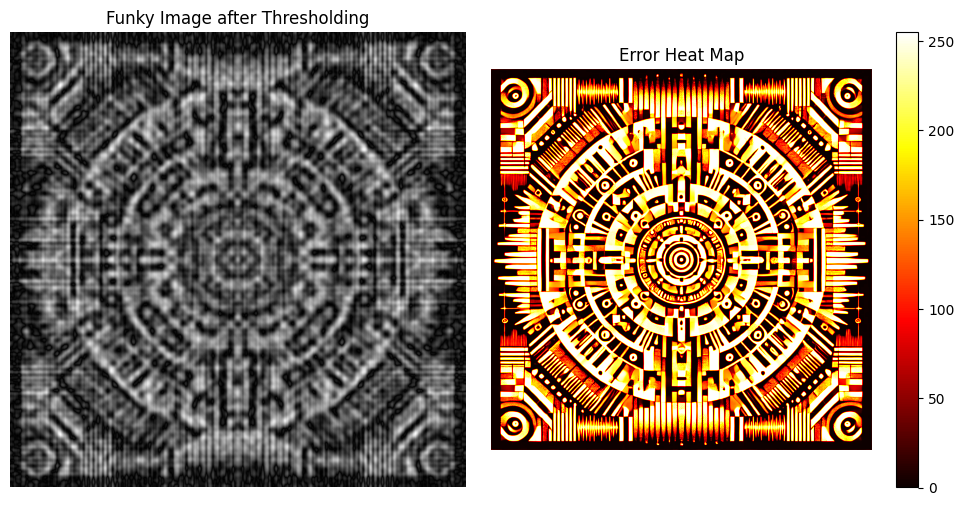

MSE: 24704.89, PSNR: 4.20 dB
Compression Ratio for owl: 0.06215858459472656


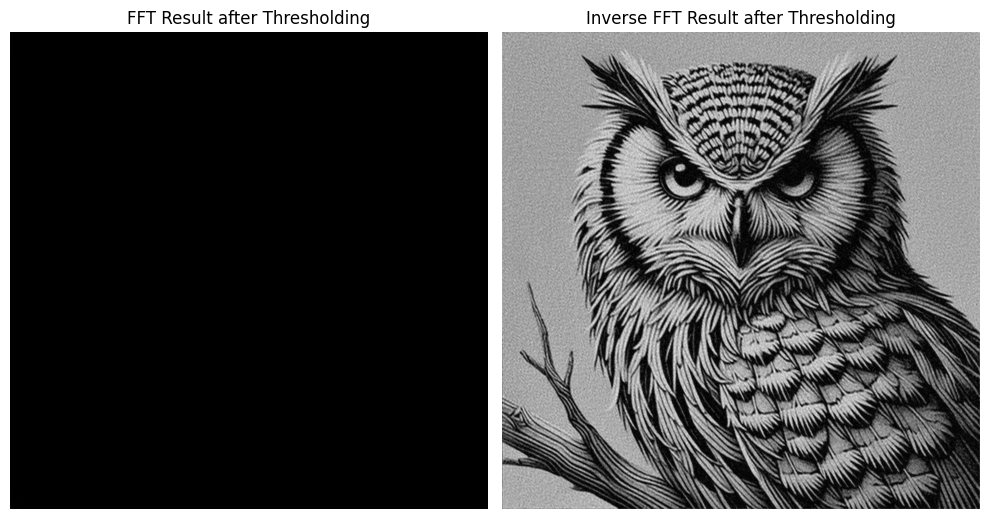

Max error of Owl image after thresholding: 254.99989077576345


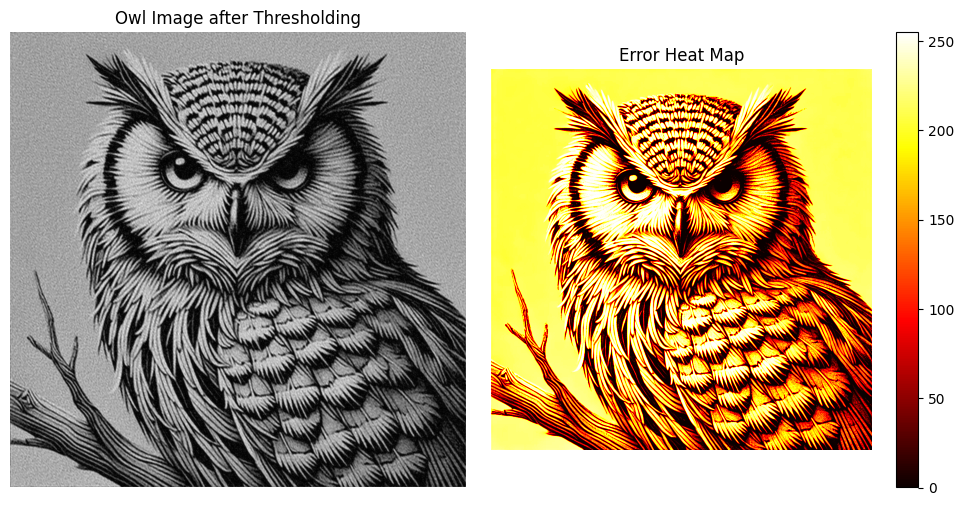

MSE: 29680.64, PSNR: 3.41 dB


In [460]:
g_T_funky = calc_g(fft_result_funky, 0, 1000, 1)
print(len(g_T_funky))
plt.plot(range(0, 1000, 10), g_T_funky)
plt.title('g(T) vs T for Funky Image')
plt.xlabel('T')
plt.ylabel('g(T)')
plt.grid()
plt.show()

#Owl Image
g_T_owl = calc_g(fft_result_owl, 0, 1000, 1)
plt.plot(range(0, 1000, 10), g_T_owl)
plt.title('g(T) vs T for Owl Image')
plt.xlabel('T')
plt.ylabel('g(T)')
plt.grid()
plt.show()

# Funky Image
image_file = 'funky.png'
ffft_threshold, g = threshold_fft(fft_result_funky, 1000000)
image_array = np.array(Image.open(image_file).convert("L"))
width, height = image_array.shape
compression_ratio = (g) / (width * height)
print("Compression Ratio for funky:", compression_ratio)
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()
axs[0].imshow(np.abs(ffft_threshold), cmap='gray')
axs[0].set_title('FFT Result after Thresholding')
axs[0].axis('off')

ifft_result = compute_ifft(ffft_threshold)

axs[1].imshow(ifft_result, cmap='gray')
axs[1].set_title('Inverse FFT Result after Thresholding')
axs[1].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ifft_result, cmap='gray')
ax[0].set_title('Funky Image after Thresholding')
ax[0].axis('off')
error = np.abs(image_array - ifft_result)
print("Max error of funky image after thresholding:", np.max(error))

cax = ax[1].imshow(error, cmap='hot')
ax[1].set_title('Error Heat Map')
ax[1].axis('off')
fig.colorbar(cax, ax=ax[1], orientation='vertical')
plt.tight_layout()
plt.show()

mse, psnr = compute_psnr(image_array, ifft_result)
print(f"MSE: {mse:.2f}, PSNR: {psnr:.2f} dB")

# Owl Image
image_file = 'owl.png'
ffft_threshold, g = threshold_fft(fft_result_owl, 100000)
image_array = np.array(Image.open(image_file).convert("L"))
width, height = image_array.shape
compression_ratio = (g) / (width * height)
print("Compression Ratio for owl:", compression_ratio)
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.flatten()
axs[0].imshow(np.abs(ffft_threshold), cmap='gray')
axs[0].set_title('FFT Result after Thresholding')
axs[0].axis('off')

ifft_result = compute_ifft(ffft_threshold)

axs[1].imshow(ifft_result, cmap='gray')
axs[1].set_title('Inverse FFT Result after Thresholding')
axs[1].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ifft_result, cmap='gray')
ax[0].set_title('Owl Image after Thresholding')
ax[0].axis('off')
error = np.abs(image_array - ifft_result)
print("Max error of Owl image after thresholding:", np.max(error))

cax = ax[1].imshow(error, cmap='hot')
ax[1].set_title('Error Heat Map')
ax[1].axis('off')
fig.colorbar(cax, ax=ax[1], orientation='vertical')
plt.tight_layout()
plt.show()

mse, psnr = compute_psnr(image_array, ifft_result)
print(f"MSE: {mse:.2f}, PSNR: {psnr:.2f} dB")




Week 4

Processing funky.png


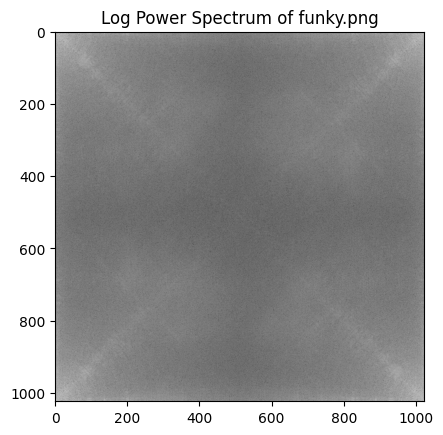

 Compression ratio r = 0.1 ---
Optimal threshold T = 62657.458
Verified compression ratio = 0.10000
MSE: 24704.88, PSNR: 4.2030 dB
 Compression ratio r = 0.01 ---
Optimal threshold T = 393996.494
Verified compression ratio = 0.01000
MSE: 24704.88, PSNR: 4.2030 dB
 Compression ratio r = 0.005 ---
Optimal threshold T = 606104.603
Verified compression ratio = 0.00500
MSE: 24704.88, PSNR: 4.2030 dB


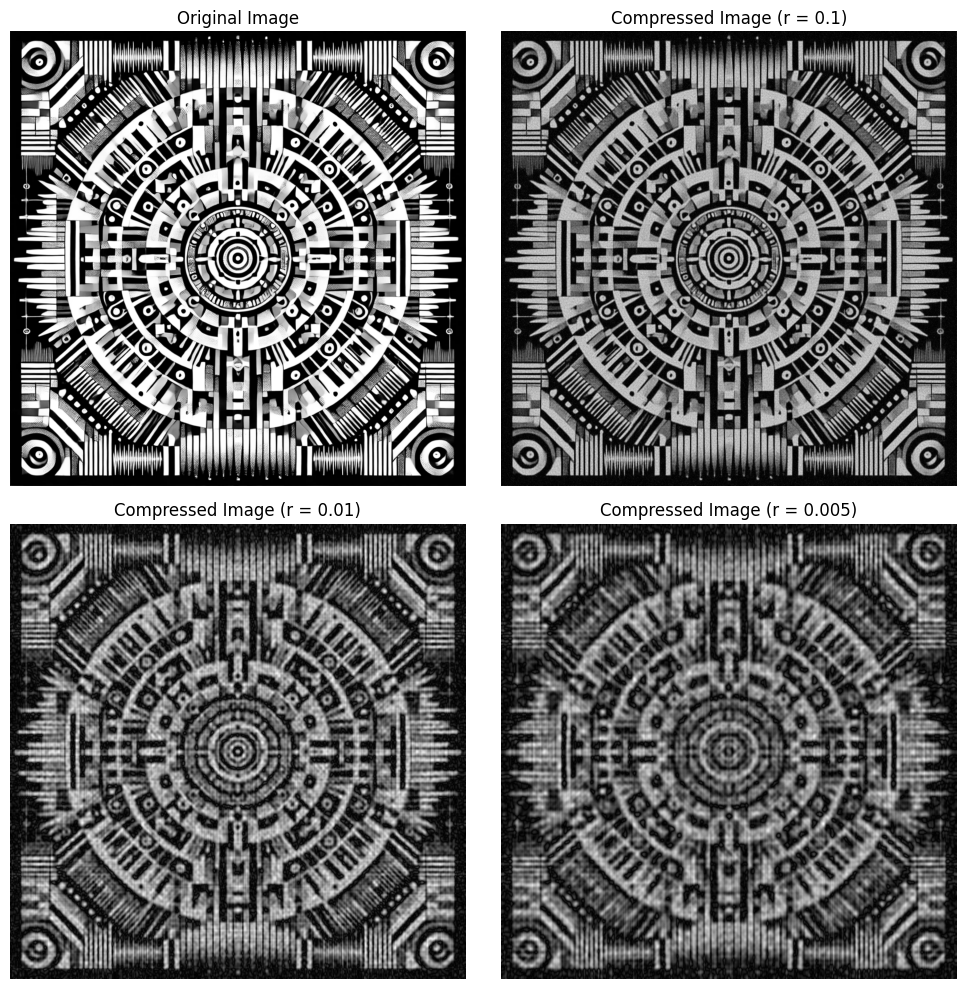

Processing owl.png


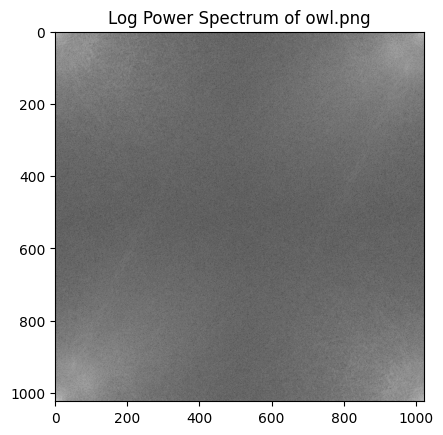

 Compression ratio r = 0.1 ---
Optimal threshold T = 68355.192
Verified compression ratio = 0.10000
MSE: 29680.64, PSNR: 3.4061 dB
 Compression ratio r = 0.01 ---
Optimal threshold T = 314056.092
Verified compression ratio = 0.01000
MSE: 29680.64, PSNR: 3.4061 dB
 Compression ratio r = 0.005 ---
Optimal threshold T = 418061.083
Verified compression ratio = 0.00500
MSE: 29680.64, PSNR: 3.4061 dB


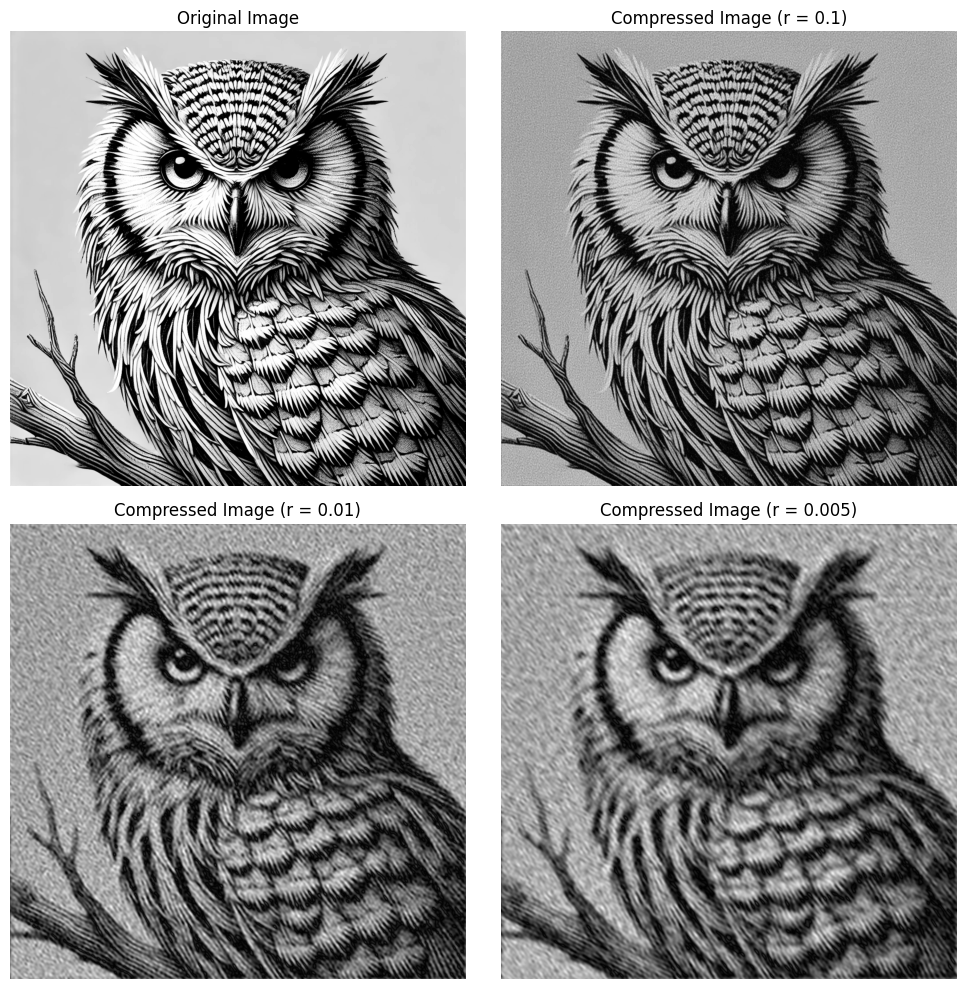

In [461]:

for image_name in ['funky.png', 'owl.png']:
        print(f"Processing {image_name}")
        fft_data, power, log_power, img_array = compute_fft(image_name)
        plt.imshow(log_power, cmap='gray')
        plt.title(f'Log Power Spectrum of {image_name}')
        plt.show()

        r = [1/10, 1/100, 1/200]
        

        # Compression
        compress_image(image_name, r)